In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd gdrive/'My Drive'/

[Errno 2] No such file or directory: 'gdrive/My Drive/'
/content/gdrive/My Drive/spidermen


In [0]:
cd spidermen/

[Errno 2] No such file or directory: 'spidermen/'
/content/gdrive/My Drive/spidermen


In [0]:
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
import torch.utils.data
from torch.nn import functional as F
import cv2

import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple

### Source: The function below is the  umeyama function from scikit-image lib
### specifically the scikit-image/skimage/transform/_geometric.py file
###  and is used to warp the inputted image while 
### training the autoencoder and decoder

def umeyama(src, dst, estimate_scale):
    """Estimate N-D similarity transformation with or without scaling.
    Parameters
    ----------
    src : (M, N) array
        Source coordinates.
    dst : (M, N) array
        Destination coordinates.
    estimate_scale : bool
        Whether to estimate scaling factor.
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    References
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [0]:
# get pair of random warped images from inputted image containing face
def random_warp(image):
    assert image.shape == (256, 256, 3)
    range_ = np.linspace(128 - 80, 128 + 80, 5)
    mapx = np.broadcast_to(range_, (5, 5))
    mapy = mapx.T

    mapx = mapx + np.random.normal(size=(5, 5), scale=5)
    mapy = mapy + np.random.normal(size=(5, 5), scale=5)

    interp_mapx = cv2.resize(mapx, (80, 80))[8:72, 8:72].astype('float32')
    interp_mapy = cv2.resize(mapy, (80, 80))[8:72, 8:72].astype('float32')

    warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)

    src_points = np.stack([mapx.ravel(), mapy.ravel()], axis=-1)
    dst_points = np.mgrid[0:65:16, 0:65:16].T.reshape(-1, 2)
    mat = umeyama(src_points, dst_points, True)[0:2]

    target_image = cv2.warpAffine(image, mat, (256, 256))

    return warped_image, target_image

In [0]:
### This is the PyTorch library's source code for the _ConvNd layer
### This is being redefined as we override the forward method
### of the Conv2d class

class _ConvNd(Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding, groups, bias):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)


### This is the PyTorch library's source code for the Conv2D layer
### As seen below, the forward method has been overriden with a custom 
### function to 
class Conv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input):
        return conv2d_same_padding(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


### A custom conv2d definition, to have the padding=same option as seen in
### TensorFlow Keras. same results in padding the input such that the output
### has the same length as the input. 

### the code below was hacked together from TensorFlow Keras source code and
### https://github.com/hanqingguo/deepfake-pytorch
### such that the output has the same length as the original input
def conv2d_same_padding(input, weight, bias=None, stride=1, 
                        padding=1, dilation=1, groups=1):

    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_rows - 1) * stride[0] + effective_filter_size_rows -
                  input_rows)
    padding_rows = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    rows_odd = (padding_rows % 2 != 0)
    padding_cols = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    cols_odd = (padding_rows % 2 != 0)

    if rows_odd or cols_odd:
        input = pad(input, [0, int(cols_odd), 0, int(rows_odd)])

    return F.conv2d(input, weight, bias, stride,
                  padding=(padding_rows // 2, padding_cols // 2),
                  dilation=dilation, groups=groups)

In [0]:
def toTensor(x):
    return torch.from_numpy(x.transpose((0, 3, 1, 2)))   

#def var_to_np(img_var):
#    return img_var.data.cpu().numpy()


class _ConvLayer(nn.Sequential):
    def __init__(self, input_features, output_features):
        super(_ConvLayer, self).__init__()
        self.add_module('conv2', Conv2d(input_features, output_features,
                                        kernel_size=5, stride=2))
        self.add_module('leakyrelu', nn.LeakyReLU(0.1, inplace=True))


class _UpScale(nn.Sequential):
    def __init__(self, input_features, output_features):
        super(_UpScale, self).__init__()
        self.add_module('conv2_', Conv2d(input_features, output_features * 4,
                                         kernel_size=3))
        self.add_module('leakyrelu', nn.LeakyReLU(0.1, inplace=True))
        self.add_module('pixelshuffler', _PixelShuffler())


class Flatten(nn.Module):

    def forward(self, input):
        output = input.view(input.size(0), -1)
        return output


class Reshape(nn.Module):

    def forward(self, input):
        output = input.view(-1, 1024, 4, 4)  # channel * 4 * 4

        return output


class _PixelShuffler(nn.Module):
    def forward(self, input):
        batch_size, c, h, w = input.size()
        rh, rw = (2, 2)
        oh, ow = h * rh, w * rw
        oc = c // (rh * rw)
        out = input.view(batch_size, rh, rw, oc, h, w)
        out = out.permute(0, 3, 4, 1, 5, 2).contiguous()
        out = out.view(batch_size, oc, oh, ow)  # channel first

        return out


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            Conv2d(64, 3, kernel_size=5, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            Conv2d(64, 3, kernel_size=5, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

In [0]:
def process_img(ori_img):
    img = cv2.resize(ori_img, (256, 256))
    range_ = np.linspace( 128-80, 128+80, 5 )
    mapx = np.broadcast_to( range_, (5,5) )
    mapy = mapx.T

    # warp image like in the training
    mapx = mapx + np.random.normal( size=(5,5), scale=5 )
    mapy = mapy + np.random.normal( size=(5,5), scale=5 )
    interp_mapx = cv2.resize(mapx, (80, 80))[8:72, 8:72].astype('float32')
    interp_mapy = cv2.resize(mapy, (80, 80))[8:72, 8:72].astype('float32')
    warped_image = cv2.remap(img, interp_mapx, interp_mapy, cv2.INTER_LINEAR)
    return warped_image

In [0]:
def predict():
    #img_f = './fiveclips.mp4_faces/frame_5980.jpg'
    img_f = './fiveclips.mp4_faces/frame_17930.jpg'
    #img_f = './testimage.jpg'
    
    device = torch.device('cuda:0')

    ori_img = cv2.imread(img_f)
    #print("ori_img shape",ori_img.shape)
    resized_face = cv2.resize(ori_img, (256, 256))
    #print("resized image shape",resized_face.shape)
    normalized_face = resized_face / 255.0
    #print("normalized image shape",normalized_face.shape)
    warped_img, _ = random_warp(normalized_face)
    #print("warped image shape",warped_img.shape)
    batch_warped_img = np.expand_dims(warped_img, axis=0)
    #print("batched warped image shape",batch_warped_img.shape)
    
    batch_warped_img = toTensor(batch_warped_img)
    batch_warped_img = batch_warped_img.to(device).float()
    
    model = Autoencoder().to(device)
    if torch.cuda.is_available():
      checkpoint = torch.load('./checkpoint/autoencoder.t7')
      model.load_state_dict(checkpoint['state'])
      model.eval()
      print('model loaded.')

    out = model.forward(batch_warped_img,'B')
    out = np.clip(out.detach().cpu().numpy()[0]*255, 0, 255).astype('uint8').transpose(1, 2, 0)
    
    print("original image \n")
    cv2_imshow(ori_img)
    #cv2.imshow('network input image', img)
    print("converted image \n")
    cv2_imshow(cv2.resize(out, (256,256)))
    cv2.waitKey(0)

model loaded.
original image 



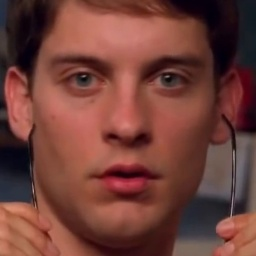

converted image 



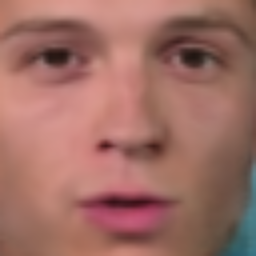

In [0]:
predict()

In [0]:
from google.colab.patches import cv2_imshow